# Wikipedia Talk Labels: Personal Attacks
This notebook works with the <a href="https://figshare.com/projects/Wikipedia_Talk/16731">Wikipedia Talk</a> dataset published by Ellery Wulczyn on Figshare, and the exercise is inspired by the <a href="https://www.kaggle.com/jigsaw-team/wikipedia-talk-labels-personal-attacks">Wikipedia Talk Labels: Personal Attacks</a> provided by the Jigsaw team on Kaggle.

The dataset contains a large historical corpus of discussion on Wikipedia Talk pages, and they are labeled by reviewers as an attack or not. This exercise attempts to do a sentimental analysis on this dataset and solve it as a binary classification problem by building and training multiple machine learning models from Scikit-Learn to predict whether a comment is offensive. The predictions by the models are evaluated using the precision, recall, and F1-score metrices.

In [1]:
# Import required packages.
import pandas as pd
import numpy as np
import urllib
import re
from string import punctuation

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import classifiers.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

---
## Data Preparation

**Acknowledgement:**

The starter code to download and load the file is given by Ellery Wulczyn on the Github, available here: <a href="https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb">Wikipedia Talk Data - Getting Started</a>.

In [4]:
# Download annotated comments and annotations
ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# Download file when running this Jupyter Notebook for the first time.
## download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
## download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [5]:
# Read in CSV files.
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t')
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

---
## Data Understanding and Preprocessing

### Data Understanding

In [6]:
comments.head(3)

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train


Just by taking a quick peek at the data can we find that the 'comment' feature needs to be processed. There are some token symbols mixed in the comment, which needs to be removed before we do the analysis.

In [7]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115864 entries, 0 to 115863
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   rev_id     115864 non-null  int64 
 1   comment    115864 non-null  object
 2   year       115864 non-null  int64 
 3   logged_in  115864 non-null  bool  
 4   ns         115864 non-null  object
 5   sample     115864 non-null  object
 6   split      115864 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 5.4+ MB


The dataset consists of 7 features in 3 data types: 2 int64 for the comment reviewer ID and the year when the comment was posted, 1 boolean for whether the commenter is logged in or not, and 4 object for the rest.

The 'split' column is the pre-determined column by the dataset provider to be used when we do train-test split.

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (15, 7), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

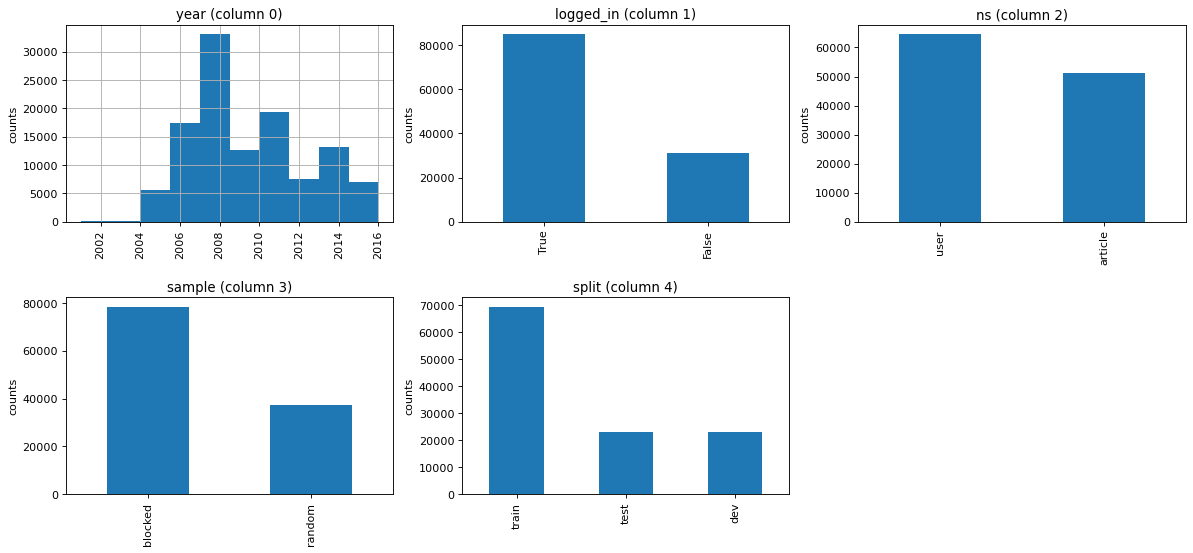

In [9]:
plotPerColumnDistribution(comments, 5, 3)

### Data Preprocessing
The main issue we need to tackle in the data preprocessing step is to clean the raw text in the 'comment' feature (Other features do not require us to process). As we can see in the data understanding step, the comment is mixed with token symbols and punctuation marks.

In addition, for any sentiment analysis or NLP project, we'd want to clean up stopwords that have no significant meaning. We'll leverage the NLTK package and use its stopwords corpus.

In [10]:
comments = comments.set_index('rev_id')

In [11]:
# label a comment as an atack if over 50% of annoatators did so.
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

comments['attack'] = labels

In [12]:
# Remove newline and tab tokens.
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [13]:
# Remove punctuation and underscore mark.
comments['comment'] = comments['comment'].str.replace(r'[^\w\s]+', '')
comments['comment'] = comments['comment'].apply(lambda x: x.replace("_", " "))

# Replace multiple space with a single space.
comments['comment'] = comments['comment'].apply(lambda x: re.sub(' +', ' ', x))

In [14]:
# Remove stopwords using nltk.
stop_words = set(stopwords.words("english"))
comments['comment'] = comments['comment'].apply(lambda x: [item for item in x.split() if item not in stop_words])
comments['comment'] = comments['comment'].str.join(" ")

In [15]:
# Display first 5 attacks.
comments[(comments['attack'] == True)].head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
801279,Iraq good USA bad,2003,False,article,random,train,True
2702703,fuck little asshole If want talk human start s...,2004,False,user,random,train,True
4632658,dick bigger hahaha,2004,False,article,blocked,train,True
6545332,renault sad little bpy driving renault clio va...,2004,True,user,blocked,train,True
6545351,renault sad little bo driving renault clio vaa...,2004,True,user,blocked,test,True


---
## Training and Evaluating Models

#### Train-Test Split by Pre-determined Label

In [16]:
# split into train and test data by the label
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [17]:
drop_labels = ['split', 'attack']

X_train = train_comments.drop(drop_labels, axis=1)
y_train = train_comments['attack']

X_test = test_comments.drop(drop_labels, axis=1)
y_test = test_comments['attack']

#### Train-Test Split using Scikit-Learn

In [18]:
X = comments.drop(drop_labels, axis=1)
y = comments['attack']

In [19]:
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We won't be using the typical train-test split with scikit-learn in this practice, but this is typically how one would do it. The 'stratify' hyperparameter will suppose to split the data in a stratified fashion by preserving the ratio of different classes in training and testing data when the split is performed.

For instance, with this dataset, the "True" value in the "attack" label counts for about 10% of the data. The training and testing will preserve this ratio by keeping 10% of training and testing data to be "True" in the "attack" label.

### Logistic Regression
The logistic regression model will only evaluate a comment by the 'comment' feature. This will serve as the "baseline", or benchmark, for our other models.

In [20]:
# Instantiate a count vectorizer and tf-idf transformer.
vect = CountVectorizer(max_features = 10000, ngram_range = (1,2))
tfidf = TfidfTransformer(norm = 'l2')

In [21]:
# fit a simple text classifier
clf = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('clf', LogisticRegression(random_state=42)),
])
clf = clf.fit(X_train['comment'], y_train)

In [22]:
auc = roc_auc_score(y_test, clf.predict_proba(X_test['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.955


#### Logistic Regression's Performance on Training Data

In [23]:
y_pred = clf.predict(X_train['comment'])

In [24]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     61447
        True       0.91      0.60      0.73      8079

    accuracy                           0.95     69526
   macro avg       0.93      0.80      0.85     69526
weighted avg       0.95      0.95      0.94     69526



In [25]:
print(confusion_matrix(y_train, y_pred))

[[60989   458]
 [ 3224  4855]]


In [26]:
f1_score(y_train, y_pred)

0.7250597371565114

#### Logistic Regression's Performance on Testing Data

In [27]:
y_pred = clf.predict(X_test['comment'])

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20422
        True       0.92      0.56      0.69      2756

    accuracy                           0.94     23178
   macro avg       0.93      0.77      0.83     23178
weighted avg       0.94      0.94      0.93     23178



In [29]:
print(confusion_matrix(y_test, y_pred))

[[20284   138]
 [ 1223  1533]]


In [30]:
f1_score(y_test, y_pred)

0.6925683306979896

### Random Forest Classifier

In [31]:
comments_copy = comments.copy()

In [32]:
# label attack column and transform none-attacks into 0 and attacks into 1.
label_attack = LabelEncoder()
comments_copy['attack'] = label_attack.fit_transform(comments_copy['attack'])

In [33]:
X_train_rfc = comments_copy.query("split=='train'")
X_test_rfc = comments_copy.query("split=='test'")

In [34]:
# Transform trainning data into a dense matrix
X_train_dtm = vect.transform(X_train_rfc['comment'])
X_test_dtm = vect.transform(X_test_rfc['comment'])

In [35]:
rfclf = RandomForestClassifier(n_estimators=200, random_state=42)
rfclf.fit(X_train_dtm, y_train)

"""
param_grid = [{
    'n_estimators' : [50, 100, 200],
    'random_state' : [42]
}]

# Use Grid Search to find best n_estimators, with the # of folds in cross validation set to 5
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv= 5)
grid_search.fit(X_train_dtm, y_train);
"""

"\nparam_grid = [{\n    'n_estimators' : [50, 100, 200],\n    'random_state' : [42]\n}]\n\n# Use Grid Search to find best n_estimators, with the # of folds in cross validation set to 5\ngrid_search = GridSearchCV(rfc, param_grid=param_grid, cv= 5)\ngrid_search.fit(X_train_dtm, y_train);\n"

In practice, we can add a lot more hyperparameters for the grid search to find best combinations of hyperparameters on the data. For the purpose of this exercise, I'll only set it to find the number of n_estimators here.

In [36]:
# grid_search.best_estimator_

In [37]:
# rfclf = grid_search.best_estimator_.fit(X_train_dtm, X_train_rfc['attack'])

#### Random Forest's Performane on Training Data

In [38]:
y_pred = rfclf.predict(X_train_dtm)

In [39]:
print(classification_report(X_train_rfc['attack'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61447
           1       1.00      0.99      0.99      8079

    accuracy                           1.00     69526
   macro avg       1.00      1.00      1.00     69526
weighted avg       1.00      1.00      1.00     69526



In [40]:
print(confusion_matrix(X_train_rfc['attack'], y_pred))

[[61432    15]
 [   77  8002]]


In [41]:
f1_score(X_train_rfc['attack'], y_pred)

0.9942842942345924

#### Random Forest's Performance on Testing Data

In [42]:
y_pred = rfclf.predict(X_test_dtm)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.98      0.97     20422
        True       0.82      0.62      0.71      2756

    accuracy                           0.94     23178
   macro avg       0.88      0.80      0.84     23178
weighted avg       0.94      0.94      0.94     23178



In [44]:
print(confusion_matrix(y_test, y_pred))

[[20042   380]
 [ 1036  1720]]


In [45]:
f1_score(y_test, y_pred)

0.7084019769357496

### Linear SVC

In [46]:
word_vect = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                            token_pattern=r'\w{1,}', stop_words='english',
                            ngram_range=(1,1), max_features=10000)
char_vect = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                            stop_words='english',
                            ngram_range=(2,6), max_features=50000)

In [47]:
lsvc = Pipeline(
    steps = [
        ('union', FeatureUnion([
            ('word_vect', word_vect),
            ('char_vect', char_vect)
        ])),
        ('clf', LinearSVC(dual=False, C=1.0, random_state=42, max_iter=4000))
    ]
)

lsvc = lsvc.fit(X_train['comment'], y_train)

#### Linear SVC's Performance on Training Data

In [48]:
y_pred = lsvc.predict(X_train['comment'])

In [49]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     61447
        True       0.97      0.92      0.95      8079

    accuracy                           0.99     69526
   macro avg       0.98      0.96      0.97     69526
weighted avg       0.99      0.99      0.99     69526



In [50]:
print(confusion_matrix(y_train, y_pred))

[[61255   192]
 [  666  7413]]


In [51]:
f1_score(y_train, y_pred)

0.9452945677123181

#### Linear SVC's Performance on Testing Data

In [52]:
y_pred = lsvc.predict(X_test['comment'])

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97     20422
        True       0.85      0.67      0.75      2756

    accuracy                           0.95     23178
   macro avg       0.90      0.83      0.86     23178
weighted avg       0.94      0.95      0.94     23178



In [54]:
print(confusion_matrix(y_test, y_pred))

[[20091   331]
 [  917  1839]]


In [55]:
f1_score(y_test, y_pred)

0.7466504263093788

---
### Conclusion
The logistic regression model is most consistent in its performance with the training and testing data, where it scores around 0.7 in F1-score on both. It is also relatively fast in training, since we set it up to only learn on the n-gram counts and tf-idf of term tokens.

The random forest classifier overfits on the training data -- it gets unreasonably high precision of 1 and a recall of 0.99 on the training data, whereas it only scores a precision of 0.82 and a precision of 0.62, resulting in an overall of 0.99 in F1-score. In contrast, the precision and recall on the testing data is relatively lower. Out of the 3 models, it also seems to take the longest to train.

The linear SVC performs better than the logistic regression, with a higher F1-score on the testing data. However, it's interesting to note that the model also appears to overfit on the training data, where it scores 0.95 in contrast to the F1-score of 0.75 it receives on the testing data.

In overall, the linear SVC model is the best of the 3 models trained and tested in terms of training time and performance on this dataset.